In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.metrics import dtw
from keras.preprocessing.sequence import pad_sequences

In [9]:
data_wear_01_15 = pd.read_excel("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/Annotated_WEAR_7001_7015_deID.xlsx", header = 7)
data_wear_16_30 = pd.read_excel("/Users/a123/Desktop/CMU/Capstone/CRS-Detection/Datasets/Annotated_WEAR_7016_7030_deID.xlsx", header = 7)

In [10]:
# Get rid of normalization summarized rows

data_wear_01_15_remove_normalized = data_wear_01_15.dropna(subset = ['PT_ID'])
data_wear_16_30_remove_normalized = data_wear_16_30.dropna(subset = ['PT_ID'])

In [11]:
df = pd.concat([data_wear_01_15_remove_normalized, data_wear_16_30_remove_normalized], axis=0, ignore_index=True)

In [12]:
df.isna().sum().sort_values(ascending=False).head(10)

Wearable Device ID                                 434
DOP                                                415
Date of PD (1_24_24)                               392
Date of Last Response Assess if No PD (1_24_24)    252
Date of last response assesment                    243
Abs Lymphocyte                                     235
Abs Neutrophil                                     235
Abs Monocyte                                       235
Total Cells infused (x10^6)                        224
Weight at time of infusion                         224
dtype: int64

In [13]:
df.shape

(434, 135)

In [14]:
df = df.drop(columns= ["Wearable Device ID"])
df

,Sample ID,PT_ID,Agent (JNJ/BMS/Caribou),Date of CAR-T infusion,DOB,Age,Date of Sample,Days in relation to CAR-T infusion,Patient experienced CRS at any point (Yes/No),"CRS on date (0 No, 1 Yes)",...,Patient experienced ICANS at any point (Yes/No),"ICANs on date (0 -no, 1 yes)",Abs Monocyte,Abs Neutrophil,Abs Lymphocyte,Dose,Weight at time of infusion,Total Cells infused (x10^6),DOP,Date of last response assesment
0,WEAR_7001_V1,7001.0,BMS,10/21/22,1939-11-16,82.986301,2022-10-21,0,Yes,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,WEAR_7001_CRS,7001.0,BMS,10/21/22,1939-11-16,82.986301,2022-10-22,1,Yes,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,WEAR_7001_V6,7001.0,BMS,10/21/22,1939-11-16,82.986301,2022-10-22,1,Yes,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,WEAR_7001_V7,7001.0,BMS,10/21/22,1939-11-16,82.986301,2022-10-23,2,Yes,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,WEAR_7001_V8,7001.0,BMS,10/21/22,1939-11-16,82.986301,2022-10-24,3,Yes,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,WEAR_7030_V11,7030.0,JNJ,2023-11-18 00:00:00,NaT,NaN,2023-11-27,9,Yes,0.0,...,No,0.0,0.2484,0.15,1.728,0.7x10^6 CART/KG,76.6,53.62,NaN,1/30/2024
430,WEAR_7030_V12,7030.0,JNJ,2023-11-18 00:00:00,NaT,NaN,2023-11-28,10,Yes,0.0,...,No,0.0,0.3780,0.12,2.730,0.7x10^6 CART/KG,76.6,53.62,NaN,1/30/2024
431,WEAR_7030_V13,7030.0,JNJ,2023-11-18 00:00:00,NaT,NaN,2023-11-29,11,Yes,0.0,...,No,0.0,0.3600,0.19,1.080,0.7x10^6 CART/KG,76.6,53.62,NaN,1/30/2024
432,WEAR_7030_V14,7030.0,JNJ,2023-11-18 00:00:00,NaT,NaN,2023-11-30,12,Yes,0.0,...,No,0.0,0.4590,0.36,0.646,0.7x10^6 CART/KG,76.6,53.62,NaN,1/30/2024


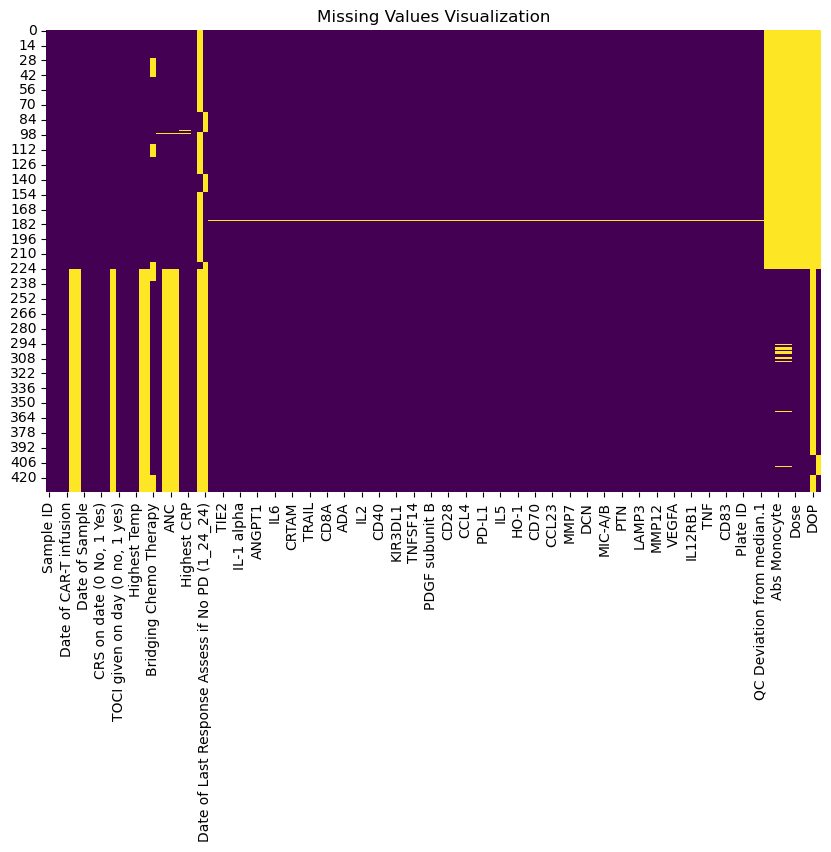

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Visualization")
plt.show()

In [6]:
missing_counts = df.isnull().sum()

# Filter columns with less than 10 missing values
columns_with_less_than_10_missing = missing_counts[missing_counts < 10].index.tolist()

# Display the column names
print("Columns with less than 10 missing values:")
for col in columns_with_less_than_10_missing:
    print(col)


Columns with less than 10 missing values:
Sample ID
PT_ID
Agent (JNJ/BMS/Caribou)
Date of CAR-T infusion
Date of Sample
Days in relation to CAR-T  infusion
Patient experienced CRS at any point (Yes/No)
CRS on date (0 No, 1 Yes)
CRS Grade 
TOCI given on day (0 no, 1 yes)
Anakinra given on day (0 no, 1 yes)
Steroids given
Highest Temp
WBC
Highest Ferritin
Highest CRP
Best Response as of 1_24_2024
IL8
TNFRSF9
TIE2
MCP-3
CD40-L
IL-1 alpha
CD244
EGF
ANGPT1
IL7
PGF
IL6
ADGRG1
MCP-1
CRTAM
CXCL11
MCP-4
TRAIL
FGF2
CXCL9
CD8A
CAIX
MUC-16
ADA
CD4
NOS3
IL2
Gal-9
VEGFR-2
CD40
IL18
GZMH
KIR3DL1
LAP TGF-beta-1
CXCL1
TNFSF14
IL33
TWEAK
PDGF subunit B
PDCD1
FASLG
CD28
CCL19
MCP-2
CCL4
IL15
Gal-1
PD-L1
CD27
CXCL5
IL5
HGF
GZMA
HO-1
CX3CL1
CXCL10
CD70
IL10
TNFRSF12A
CCL23
CD5
CCL3
MMP7
ARG1
NCR1
DCN
TNFRSF21
TNFRSF4
MIC-A/B
CCL17
ANGPT2
PTN
CXCL12
IFN-gamma
LAMP3
CASP-8
ICOSLG
MMP12
CXCL13
PD-L2
VEGFA
IL4
LAG3
IL12RB1
IL13
CCL20
TNF
KLRD1
GZMB
CD83
IL12
CSF-1
Plate ID
QC Warning
QC Deviation from median
Q

In [16]:
len(columns_with_less_than_10_missing)/len(missing_counts)

0.837037037037037

In [8]:
data = df[columns_with_less_than_10_missing].dropna()
data

,Sample ID,PT_ID,Agent (JNJ/BMS/Caribou),Date of CAR-T infusion,Date of Sample,Days in relation to CAR-T infusion,Patient experienced CRS at any point (Yes/No),"CRS on date (0 No, 1 Yes)",CRS Grade,"TOCI given on day (0 no, 1 yes)",...,TNF,KLRD1,GZMB,CD83,IL12,CSF-1,Plate ID,QC Warning,QC Deviation from median,QC Deviation from median.1
0,WEAR_7001_V1,7001.0,BMS,10/21/22,2022-10-21,0,Yes,1.0,1.0,0.0,...,3.78952,4.53595,0.26781,2.6916,5.68955,9.60013,ADRO04_IO_Plate01_11082023,Pass,0.039684,0.047985
1,WEAR_7001_CRS,7001.0,BMS,10/21/22,2022-10-22,1,Yes,1.0,1.0,1.0,...,5.22946,4.58525,3.0442,2.93595,6.04079,9.90944,ADRO04_IO_Plate01_11082023,Pass,0.084744,0.129946
2,WEAR_7001_V6,7001.0,BMS,10/21/22,2022-10-22,1,Yes,1.0,1.0,1.0,...,5.68099,4.63965,1.86368,3.05545,7.01733,10.14298,ADRO04_IO_Plate01_11082023,Pass,0.152914,0.127925
3,WEAR_7001_V7,7001.0,BMS,10/21/22,2022-10-23,2,Yes,0.0,0.0,0.0,...,5.97459,5.02866,3.56284,3.18243,8.09645,10.0535,ADRO04_IO_Plate01_11082023,Pass,0.079434,-0.053275
4,WEAR_7001_V8,7001.0,BMS,10/21/22,2022-10-24,3,Yes,0.0,0.0,0.0,...,6.24313,5.93346,4.73769,3.80248,8.19106,10.04966,ADRO04_IO_Plate01_11082023,Pass,0.127975,-0.065034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429,WEAR_7030_V11,7030.0,JNJ,2023-11-18 00:00:00,2023-11-27,9,Yes,0.0,0.0,0.0,...,5.47644,6.53635,6.37216,3.011,5.87419,9.84772,ADRO04_IO_Plate08_01032024,Pass,-0.053380,-0.177675
430,WEAR_7030_V12,7030.0,JNJ,2023-11-18 00:00:00,2023-11-28,10,Yes,0.0,0.0,0.0,...,5.15134,6.87243,5.34165,3.30534,6.24324,10.11793,ADRO04_IO_Plate08_01032024,Pass,-0.212719,-0.153385
431,WEAR_7030_V13,7030.0,JNJ,2023-11-18 00:00:00,2023-11-29,11,Yes,0.0,0.0,0.0,...,4.70588,6.24814,3.66923,3.11226,6.06368,9.7969,ADRO04_IO_Plate08_01032024,Pass,-0.023630,0.044565
432,WEAR_7030_V14,7030.0,JNJ,2023-11-18 00:00:00,2023-11-30,12,Yes,0.0,0.0,0.0,...,4.50333,5.57667,3.00101,3.17512,6.32569,9.60039,ADRO04_IO_Plate08_01032024,Pass,-0.017291,-0.120686


In [9]:
# Normalize the time series data
data = data.drop(columns=['Sample ID','Agent (JNJ/BMS/Caribou)','Date of CAR-T infusion','Days in relation to CAR-T  infusion'
,'Patient experienced CRS at any point (Yes/No)','Best Response as of 1_24_2024','Plate ID','QC Warning'], axis=0)
data["Highest Ferritin"] = np.where(data["Highest Ferritin"]==">33500","33500",data["Highest Ferritin"])
data.replace("No Data", np.nan, inplace=True)
data = data.dropna()
data = data.apply(pd.to_numeric, errors='coerce')
data['Date of Sample'] = pd.to_datetime(data['Date of Sample'])

In [7]:
grouped = data.groupby('PT_ID').apply(lambda x:x.sort_values("Date of Sample"))
grouped = grouped.reset_index(drop=True)
biomarker_columns = [col for col in data.columns if col not in ['PT_ID',"Date of Sample","CRS Grade",'CRS on date (0 No, 1 Yes)']]
biomarker_columns = ['IL6']
patients_data = [group[biomarker_columns].values for _, group in grouped.groupby('PT_ID')]



NameError: name 'data' is not defined

In [11]:
biomarker_columns

['IL6']

In [12]:
## Padding
# Step 3: Pad sequences to ensure equal length (fill missing values with NaN)
padded_patients_data = pad_sequences(patients_data, dtype='float32', padding='post', value=0)

# Step 4: Convert to a 3D array
patients_data_3d = np.array(padded_patients_data)

# The resulting 3D array
print("Shape of 3D array:", patients_data_3d.shape)
print(patients_data_3d)

Shape of 3D array: (30, 20, 1)
[[[ 4.75454]
  [ 6.62383]
  [ 6.70536]
  [12.08822]
  [12.06005]
  [10.11295]
  [ 8.78565]
  [ 8.41455]
  [ 8.85547]
  [ 8.79098]
  [ 8.90191]
  [10.95929]
  [ 0.     ]
  [ 0.     ]
  [ 0.     ]
  [ 0.     ]
  [ 0.     ]
  [ 0.     ]
  [ 0.     ]
  [ 0.     ]]

 [[ 3.92939]
  [ 4.29395]
  [ 3.90488]
  [ 4.87621]
  [ 5.03164]
  [ 5.23761]
  [ 5.9185 ]
  [ 5.84745]
  [10.33626]
  [ 8.53225]
  [ 7.76603]
  [ 7.09284]
  [ 6.71909]
  [ 7.74172]
  [ 7.09481]
  [ 6.86619]
  [ 7.18041]
  [ 0.     ]
  [ 0.     ]
  [ 0.     ]]

 [[ 4.70522]
  [ 4.94987]
  [ 4.93701]
  [ 7.19556]
  [ 7.6284 ]
  [12.14361]
  [10.78406]
  [ 9.16792]
  [ 8.87761]
  [ 8.36041]
  [ 7.99942]
  [ 7.56638]
  [ 7.59042]
  [ 7.7143 ]
  [ 7.95793]
  [ 8.18169]
  [ 8.32659]
  [ 7.73235]
  [ 0.     ]
  [ 0.     ]]

 [[ 4.50905]
  [ 4.42806]
  [ 4.41855]
  [ 4.04472]
  [ 4.1098 ]
  [ 5.78366]
  [ 6.02429]
  [ 5.69872]
  [ 5.07577]
  [ 4.80067]
  [ 4.57881]
  [ 4.56658]
  [ 4.27669]
  [ 4.28313]
 

In [13]:
[patient.shape[0] for patient in patients_data]

[12,
 17,
 18,
 16,
 12,
 14,
 10,
 17,
 18,
 15,
 16,
 12,
 6,
 20,
 17,
 12,
 14,
 16,
 12,
 2,
 14,
 14,
 15,
 15,
 20,
 4,
 13,
 14,
 19,
 16]

In [50]:
min_length = 10
filtered_patients_data = [patient for patient in patients_data if patient.shape[0] >= min_length]

patients_data_truncated = [patient[:min_length, :] for patient in filtered_patients_data]



In [51]:
patients_data_truncated

[array([[ 4.75454],
        [ 6.62383],
        [ 6.70536],
        [12.08822],
        [12.06005],
        [10.11295],
        [ 8.78565],
        [ 8.41455],
        [ 8.85547],
        [ 8.79098]]),
 array([[ 3.92939],
        [ 4.29395],
        [ 3.90488],
        [ 4.87621],
        [ 5.03164],
        [ 5.23761],
        [ 5.9185 ],
        [ 5.84745],
        [10.33626],
        [ 8.53225]]),
 array([[ 4.70522],
        [ 4.94987],
        [ 4.93701],
        [ 7.19556],
        [ 7.6284 ],
        [12.14361],
        [10.78406],
        [ 9.16792],
        [ 8.87761],
        [ 8.36041]]),
 array([[4.50905],
        [4.42806],
        [4.41855],
        [4.04472],
        [4.1098 ],
        [5.78366],
        [6.02429],
        [5.69872],
        [5.07577],
        [4.80067]]),
 array([[ 3.57279],
        [ 3.25064],
        [ 3.25444],
        [ 3.79744],
        [ 4.44372],
        [ 4.82209],
        [ 6.88621],
        [10.91516],
        [ 8.80283],
        [ 8.68078]]),


In [52]:
# Each Sub-Array is Treated as a Separate Time Series:
scaler = TimeSeriesScalerMeanVariance()
patient_data_normalized = scaler.fit_transform(patients_data_truncated)

33.763 --> 69.980 --> 72.449 --> 72.499 --> 72.594 --> 72.558 --> 72.654 --> 72.691 --> 72.772 --> 72.753 --> 72.812 --> 72.789 --> 72.831 --> 72.808 --> 72.844 --> 74.625 --> 77.220 --> 77.614 --> 77.578 --> 77.596 --> 77.588 --> 77.591 --> 77.589 --> 77.590 --> 77.589 --> 77.590 --> 77.589 --> 77.589 --> 


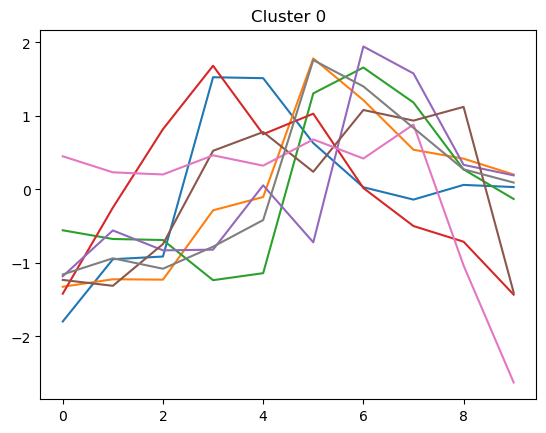

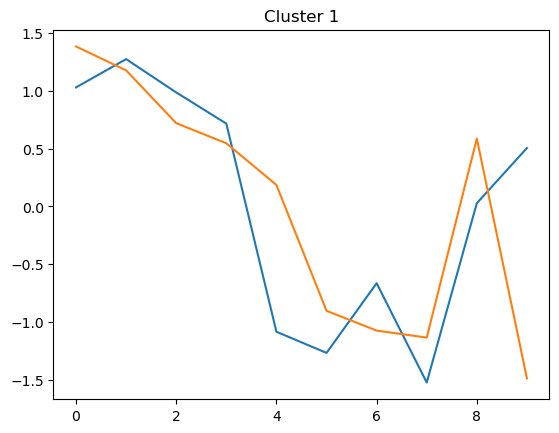

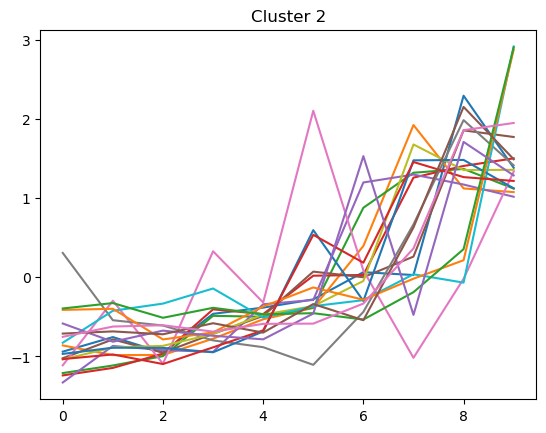

Cluster assignments: [0 2 0 0 2 0 0 2 2 2 1 0 2 0 2 2 2 2 1 2 2 2 2 0 2 2 2]


In [53]:
n_clusters = 3  # Choose the number of clusters
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", max_iter=50, verbose=True, random_state = 12)
labels = model.fit_predict(patient_data_normalized)

# Step 3: Visualize cluster assignments
for cluster_idx in range(n_clusters):
    plt.figure()
    for i, patient in enumerate(patient_data_normalized[labels == cluster_idx]):
        plt.plot(patient[:, 0])  # Plot the first biomarker for simplicity
    plt.title(f"Cluster {cluster_idx}")
    plt.show()

# Print cluster assignments for each patient
print("Cluster assignments:", labels)

In [55]:
label_df

,PT_ID,Cluster_Label
0,7001.0,0
1,7002.0,2
2,7003.0,0
3,7004.0,0
4,7005.0,2
5,7006.0,0
6,7007.0,0
7,7008.0,2
8,7009.0,2
9,7010.0,2


In [56]:
from sklearn.metrics import silhouette_score

num_patients = patient_data_normalized.shape[0]

silhouette_avg = silhouette_score(patient_data_normalized.reshape(num_patients, -1), labels, metric="euclidean")
print(f"Silhouette Score: {silhouette_avg}")




Silhouette Score: 0.3456849988528702


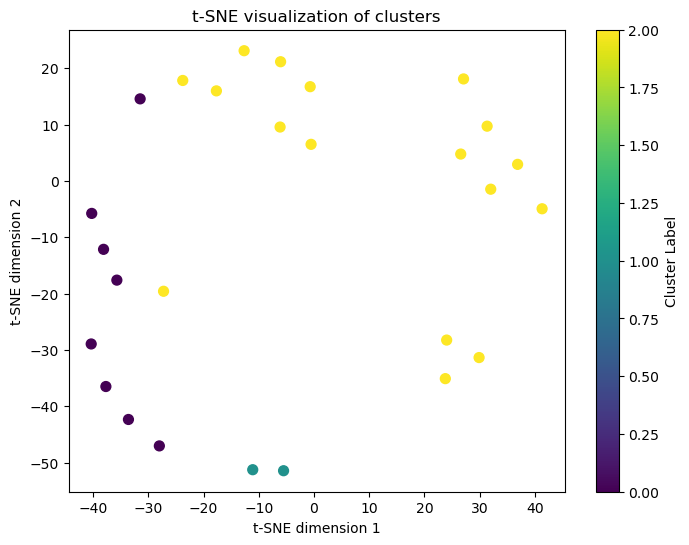

In [57]:
from sklearn.manifold import TSNE
n_patients, n_time_steps, n_features = patient_data_normalized.shape


# Step 2: Apply t-SNE with appropriate perplexity
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
data_tsne = tsne.fit_transform(patient_data_normalized.reshape(num_patients, -1))

# Step 3: Plot the t-SNE embedding with cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=labels, cmap='viridis', s=50)
plt.title('t-SNE visualization of clusters')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [58]:
filtered_pt_ids = [pt_id for pt_id, patient in zip(grouped['PT_ID'].unique(), patients_data) if patient.shape[0] >= 10]

# Step 6: Create a DataFrame to map PT_IDs with cluster labels
label_df = pd.DataFrame({
    'PT_ID': filtered_pt_ids,
    'Cluster_Label': labels
})

# Step 7: Merge the label DataFrame back with the original dataset
# This assumes the original 'data' DataFrame has a 'PT_ID' column
data_with_labels = pd.merge(data, label_df, on='PT_ID', how='left')

# Check the dataset with cluster labels attached
print(data_with_labels.head())

    PT_ID Date of Sample  CRS on date (0 No, 1 Yes)  CRS Grade   \
0  7001.0     2022-10-21                        1.0         1.0   
1  7001.0     2022-10-22                        1.0         1.0   
2  7001.0     2022-10-22                        1.0         1.0   
3  7001.0     2022-10-23                        0.0         0.0   
4  7001.0     2022-10-24                        0.0         0.0   

   TOCI given on day (0 no, 1 yes)  Anakinra given on day (0 no, 1 yes)  \
0                              0.0                                  0.0   
1                              1.0                                  0.0   
2                              1.0                                  0.0   
3                              0.0                                  0.0   
4                              0.0                                  0.0   

   Steroids given  Highest Temp  WBC  Highest Ferritin  ...    CCL20      TNF  \
0             0.0         101.8  2.1             178.0  ...  8.96

In [59]:
label_df = label_df.merge(df[['PT_ID','Patient experienced CRS at any point (Yes/No)']],on="PT_ID",how='left').drop_duplicates()
label_df

,PT_ID,Cluster_Label,Patient experienced CRS at any point (Yes/No)
0,7001.0,0,Yes
12,7002.0,2,Yes
29,7003.0,0,Yes
48,7004.0,0,No
64,7005.0,2,Yes
78,7006.0,0,No
92,7007.0,0,Yes
103,7008.0,2,Yes
120,7009.0,2,Yes
138,7010.0,2,Yes


In [60]:
label_df[label_df.Cluster_Label==0]

,PT_ID,Cluster_Label,Patient experienced CRS at any point (Yes/No)
0,7001.0,0,Yes
29,7003.0,0,Yes
48,7004.0,0,No
78,7006.0,0,No
92,7007.0,0,Yes
169,7012.0,0,No
201,7015.0,0,No
350,7027.0,0,Yes


In [61]:
label_df[label_df.Cluster_Label==1]

,PT_ID,Cluster_Label,Patient experienced CRS at any point (Yes/No)
153,7011.0,1,Yes
272,7021.0,1,Yes


In [62]:
label_df[label_df.Cluster_Label==2]

,PT_ID,Cluster_Label,Patient experienced CRS at any point (Yes/No)
12,7002.0,2,Yes
64,7005.0,2,Yes
103,7008.0,2,Yes
120,7009.0,2,Yes
138,7010.0,2,Yes
181,7014.0,2,Yes
218,7016.0,2,No
230,7017.0,2,Yes
244,7018.0,2,Yes
260,7019.0,2,Yes


In [28]:
def draw_single_patient_IL6(data, pt_id):
    df_pt = data[data['PT_ID']==pt_id]
    df_pt['Date of Sample'] = pd.to_datetime(df_pt['Date of Sample'])
    plt.figure(figsize=(10,6))
    plt.plot(df_pt['Date of Sample'], df_pt['IL6'],marker='o', linestyle='-')

    plt.xlabel('Date')
    plt.ylabel('IL6')
    plt.title(f'IL6 Over Time for Patient ID {pt_id}')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()

In [63]:
def draw_cluster_patient_IL6(data, cluster_id):
    # Filter the data to include only patients in the specified cluster
    df_cluster = data[data['Cluster_Label'] == cluster_id]
    
    # Set up the plot
    plt.figure(figsize=(10, 6))
    plt.title(f'IL-6 Time Series for Cluster {cluster_id}')
    plt.xlabel('Time (Days)')
    plt.ylabel('IL-6 Level')
    
    # Plot the IL-6 time series for each patient in the cluster
    for pt_id in df_cluster['PT_ID'].unique():
        # Extract IL-6 data for the patient
        patient_data = df_cluster[df_cluster['PT_ID'] == pt_id].sort_values('Date of Sample')
        il6_levels = patient_data['IL6'].values
        # Plot the time series
        plt.plot(il6_levels, label=f'Patient {pt_id}')
    
    # Add a legend
    plt.legend()
    # Display the plot
    plt.show()


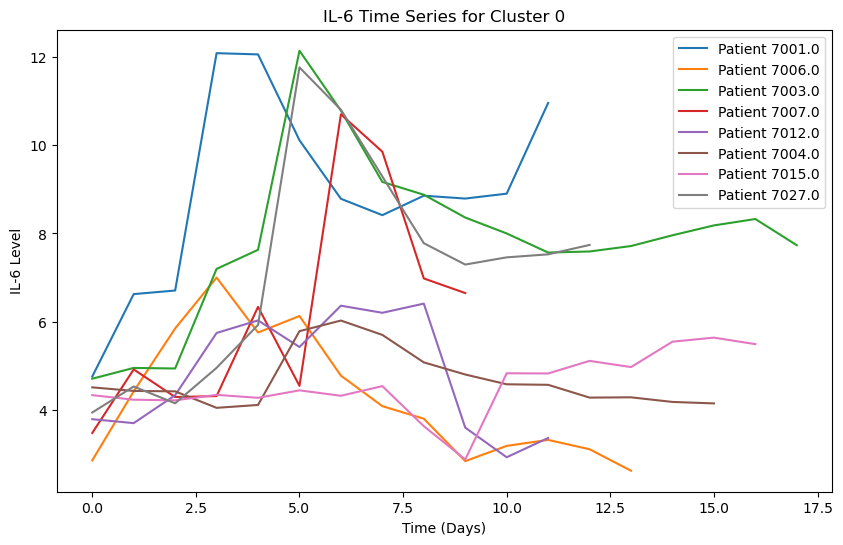

In [65]:
draw_cluster_patient_IL6(data_with_labels,0)

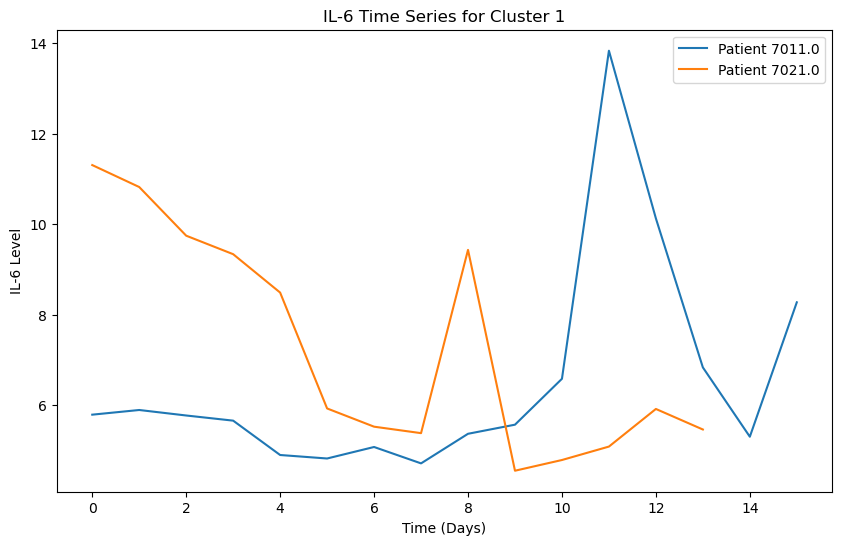

In [66]:
draw_cluster_patient_IL6(data_with_labels,1)

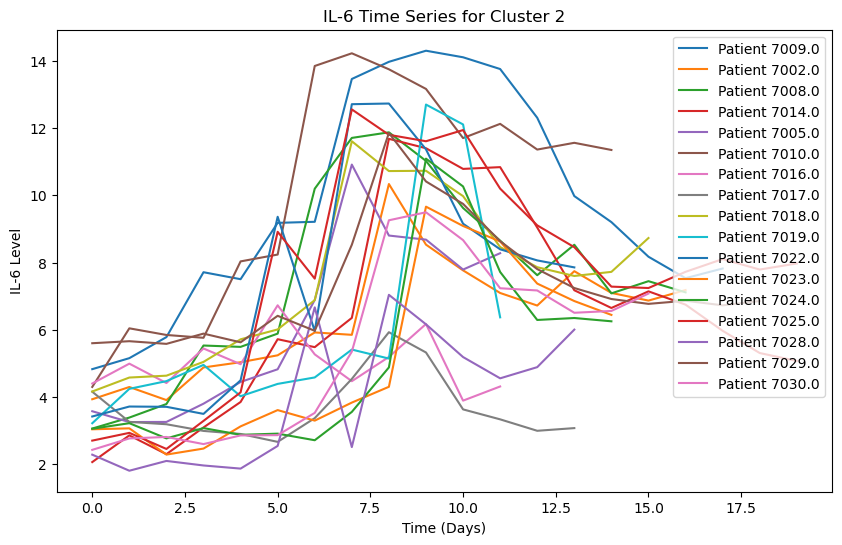

In [67]:
draw_cluster_patient_IL6(data_with_labels,2)

/var/folders/9q/_q_h4th94vj56dq6c3yv3gj80000gn/T/ipykernel_65993/2476611320.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pt['Date of Sample'] = pd.to_datetime(df_pt['Date of Sample'])


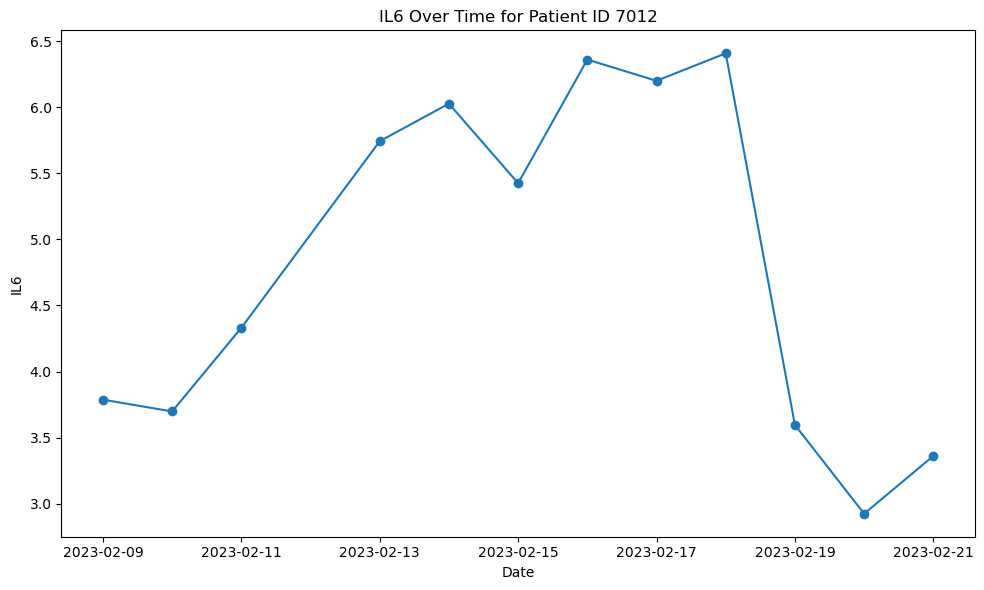

In [31]:
draw_patient_IL6(df,7012)

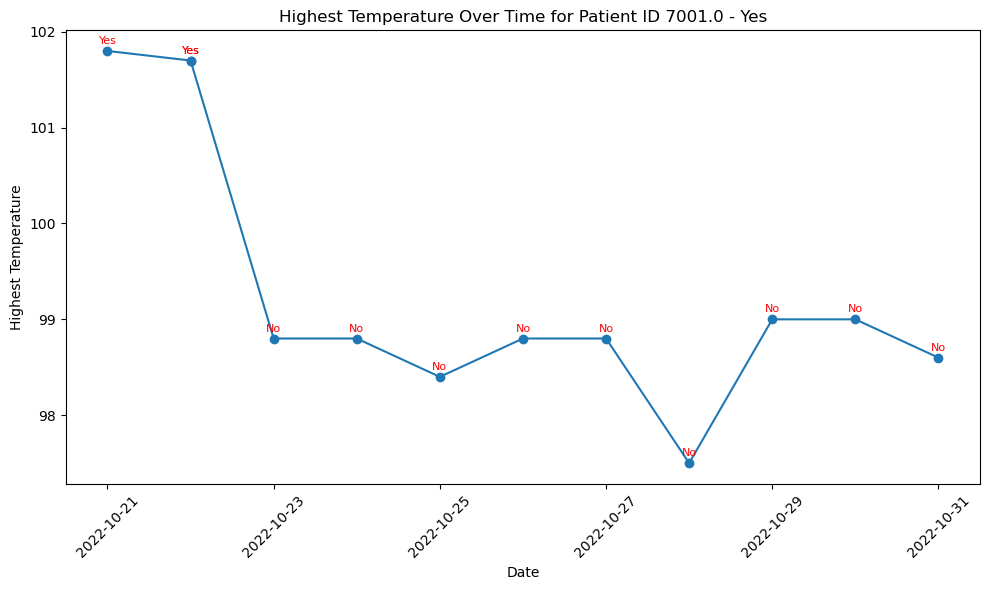

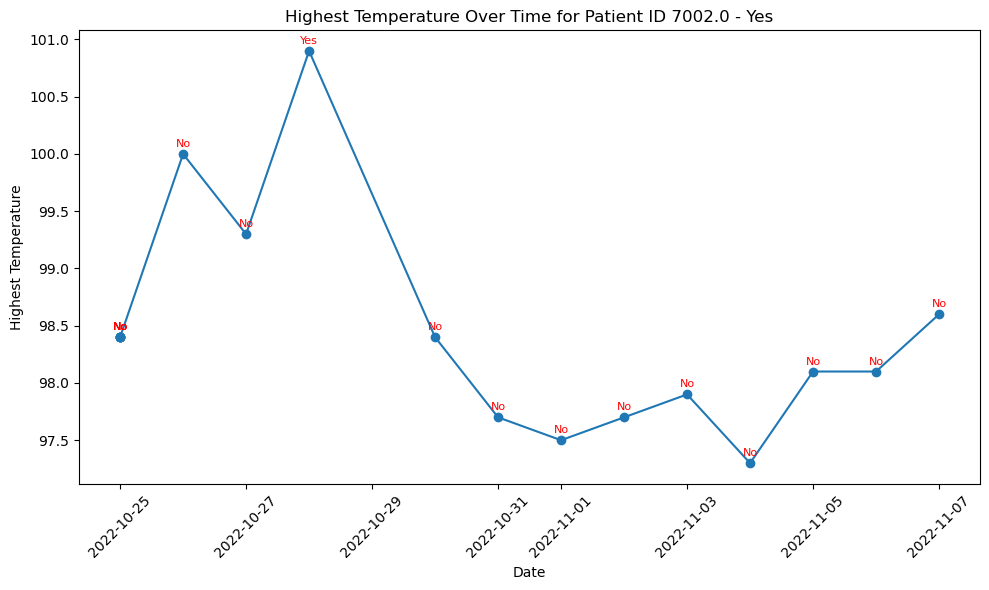

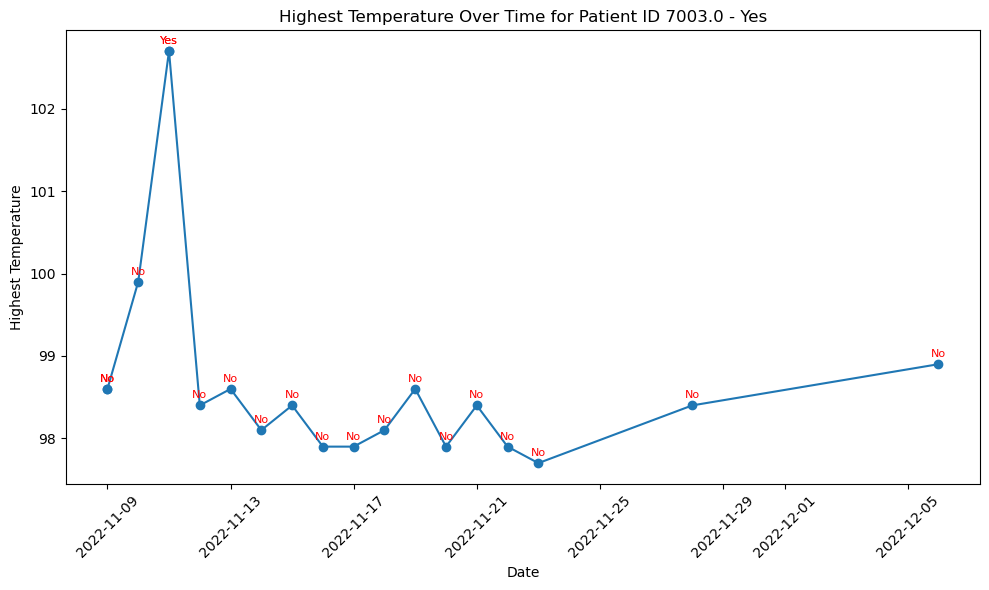

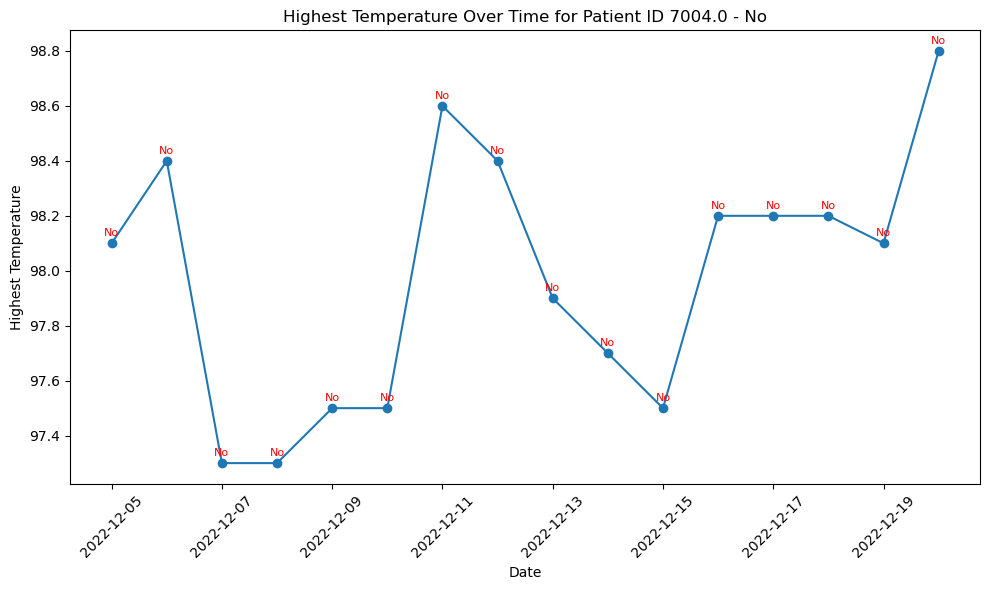

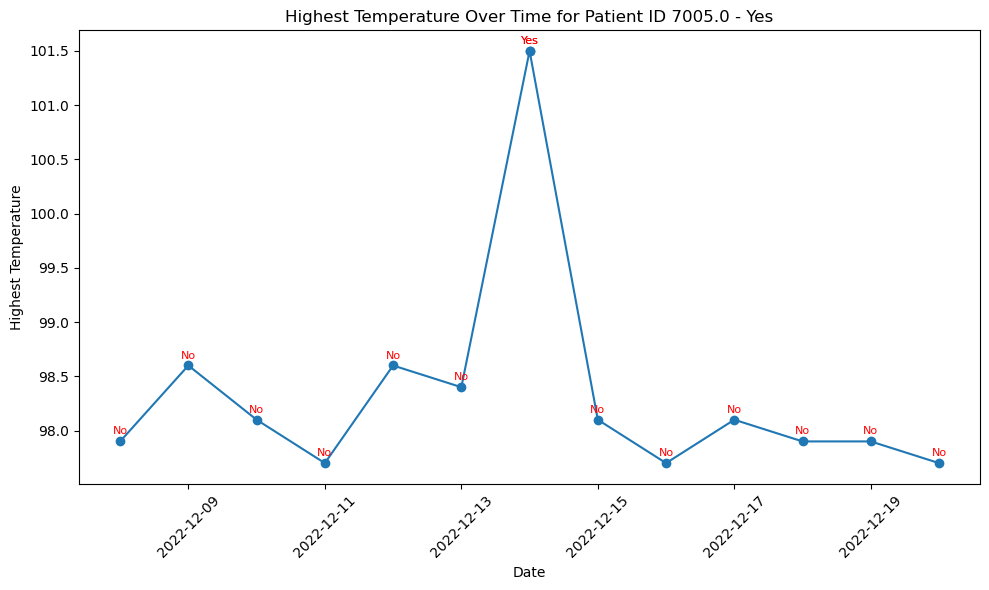

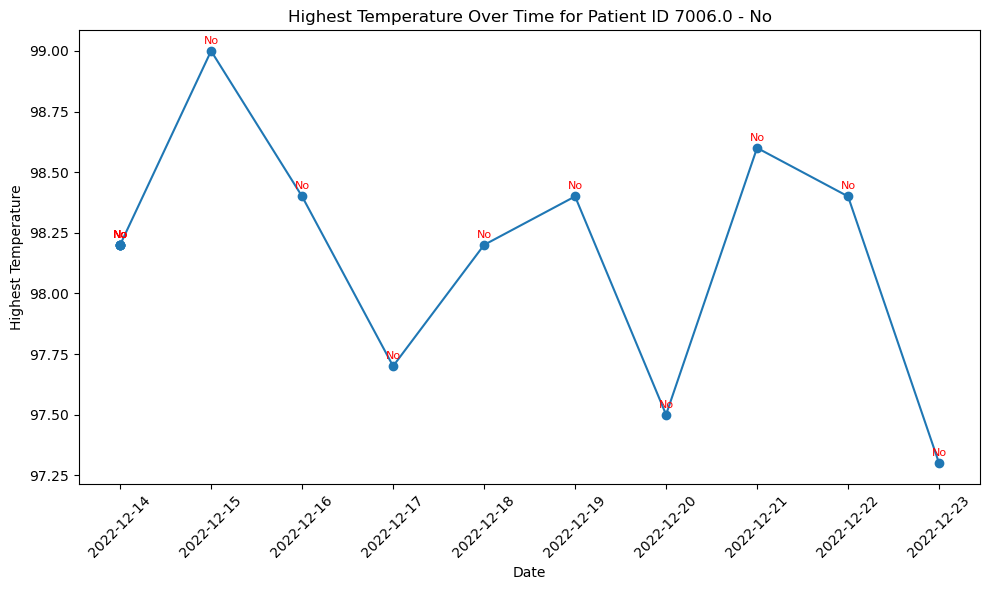

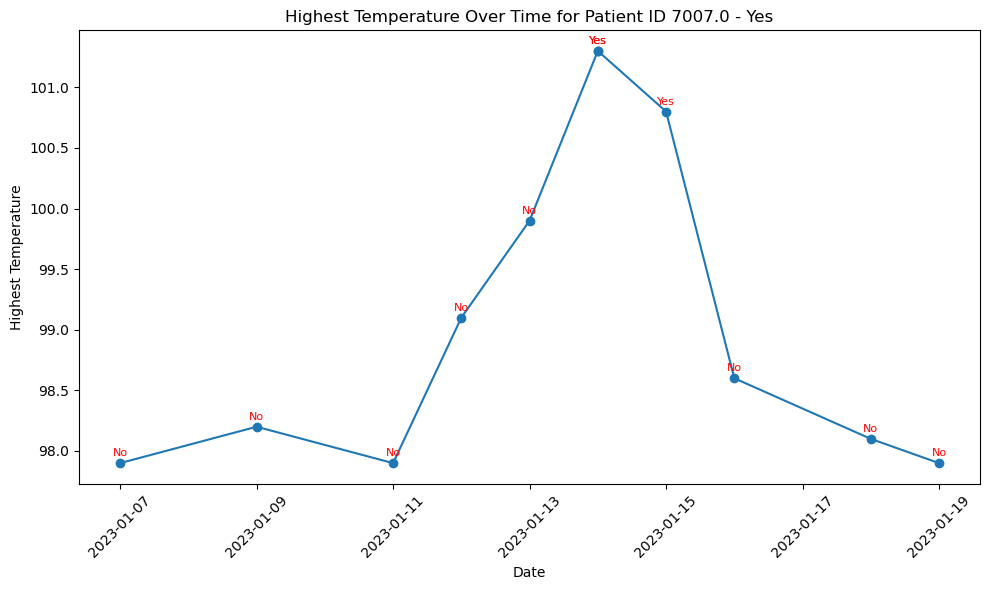

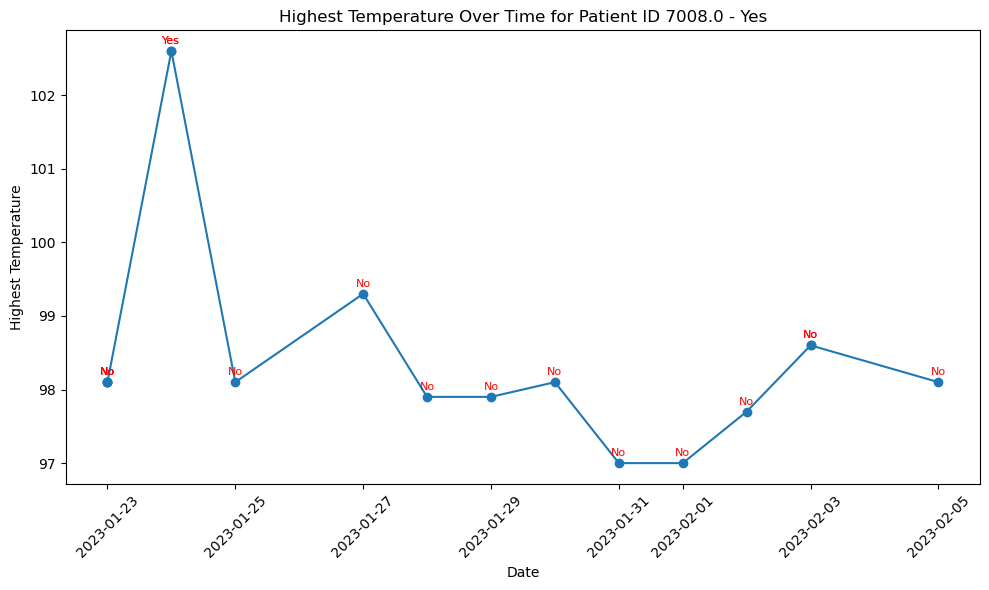

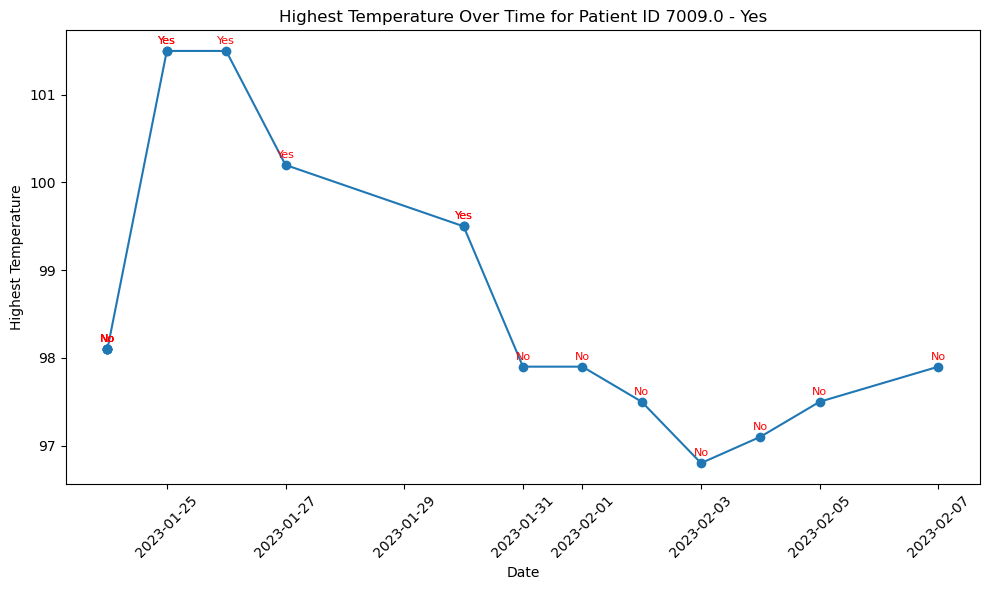

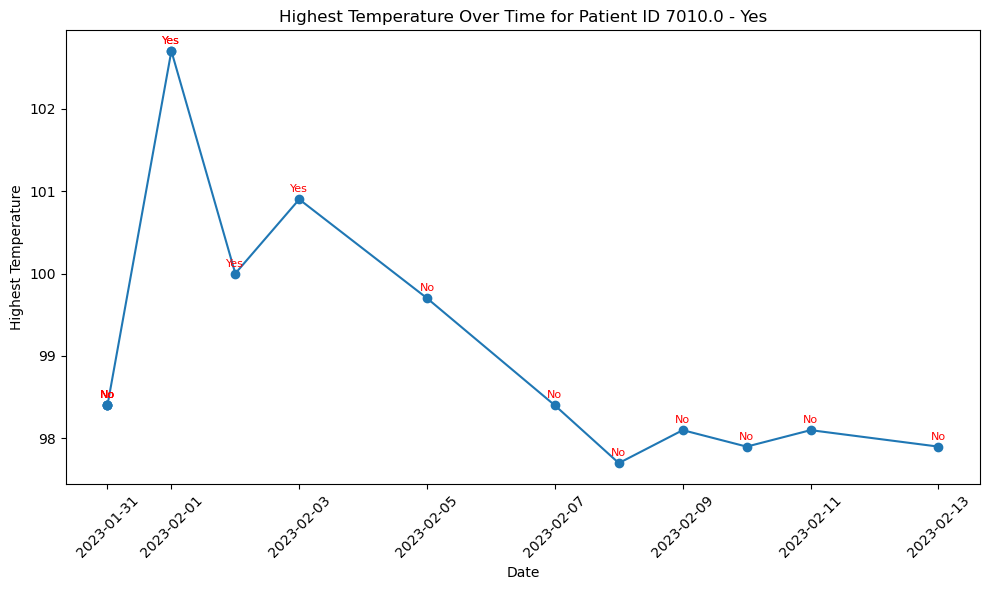

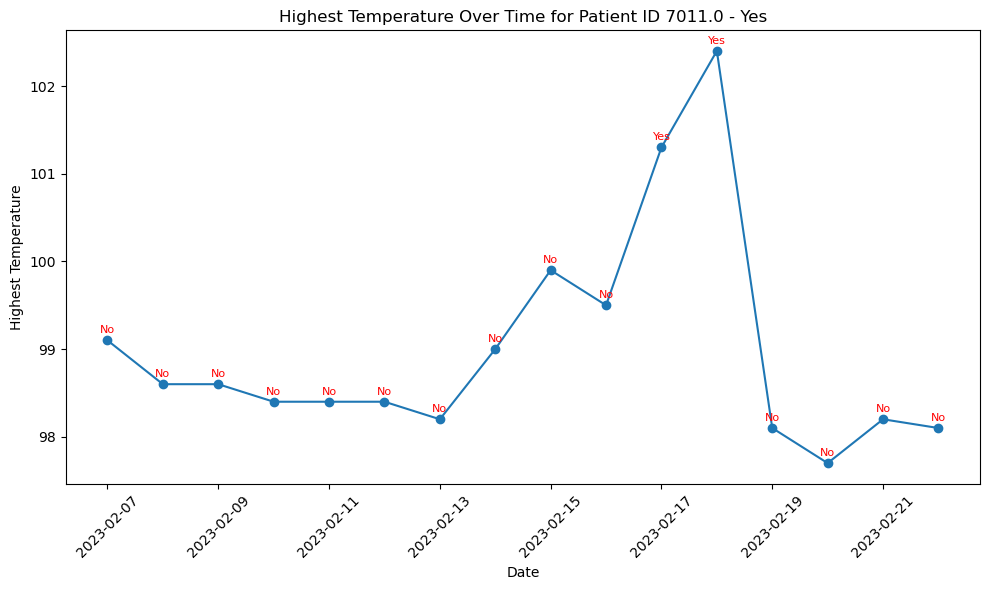

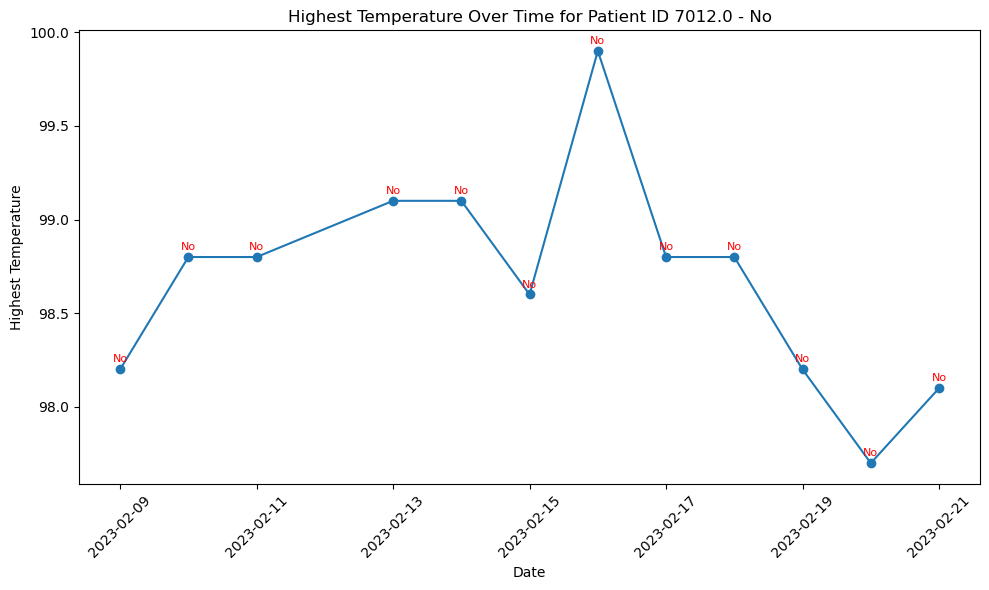

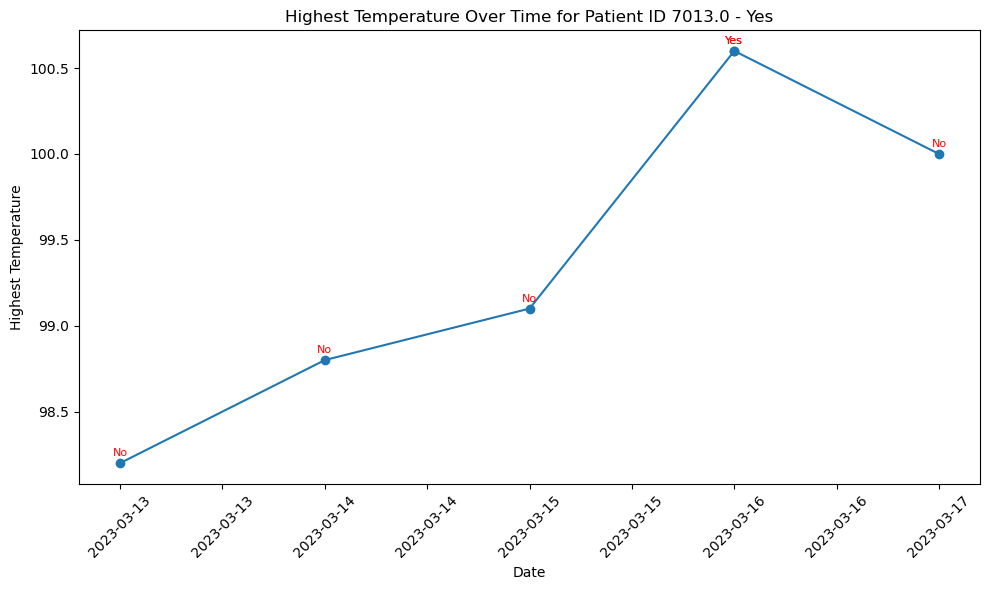

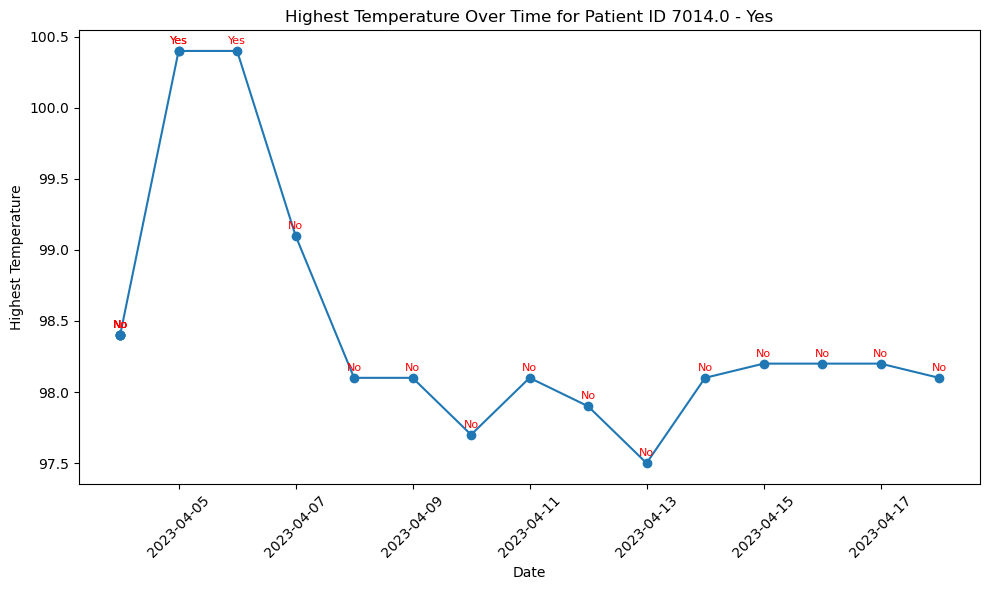

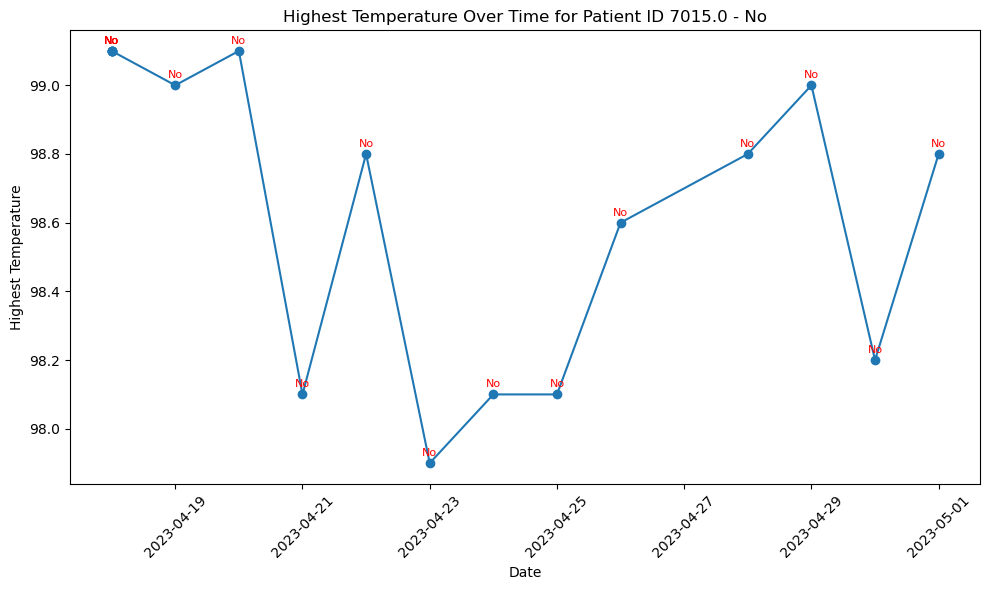

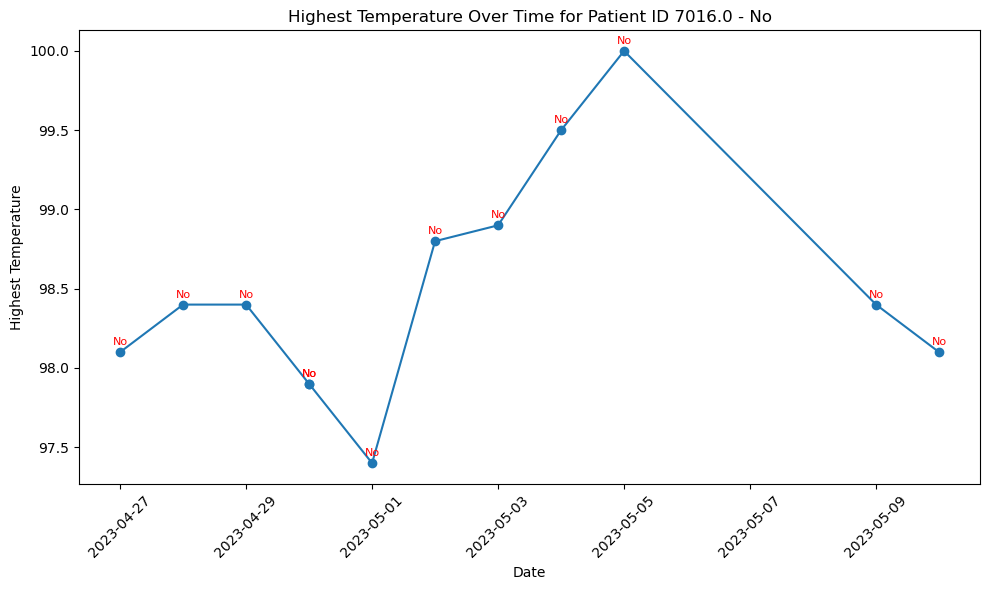

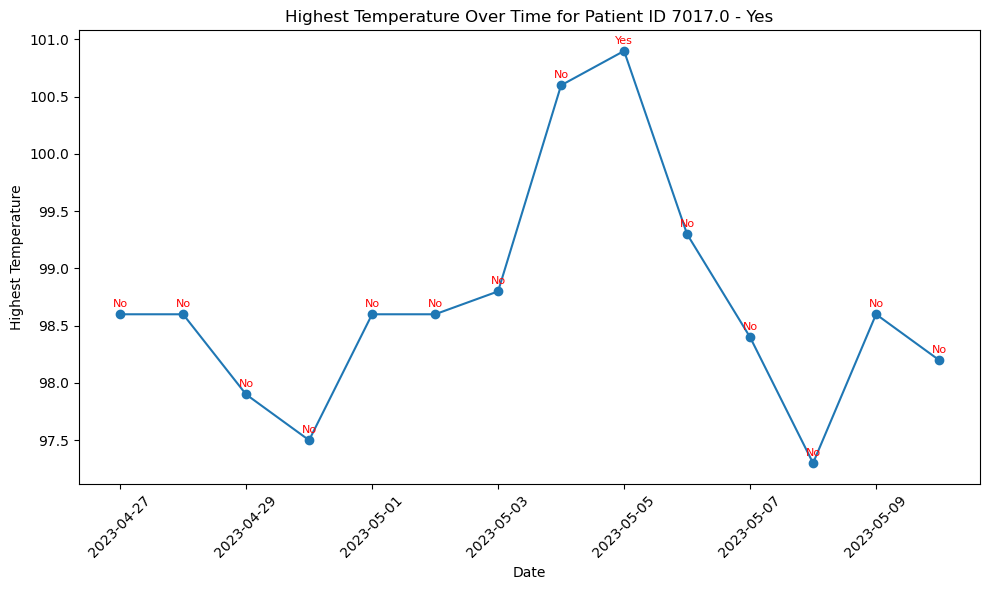

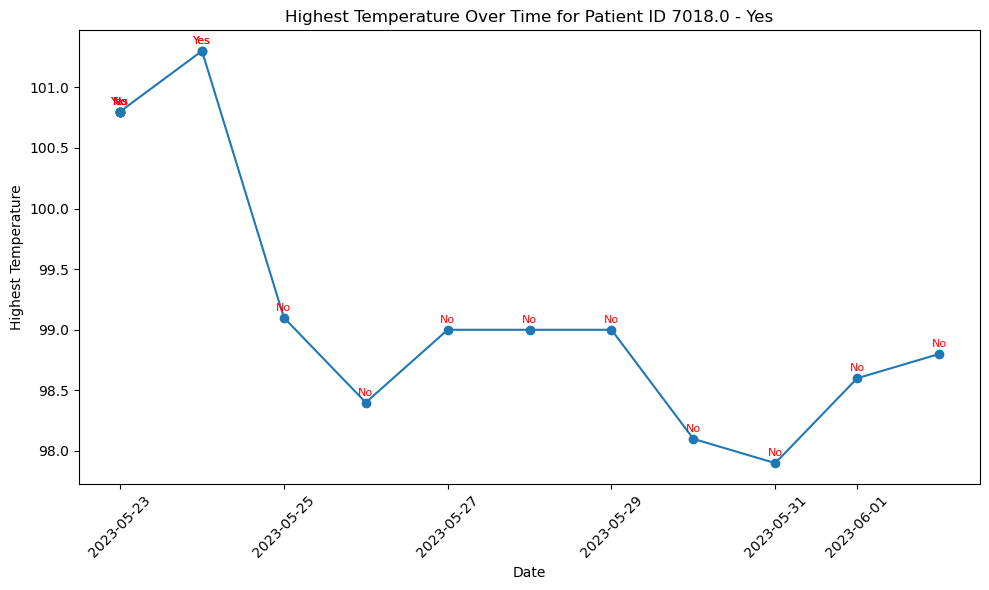

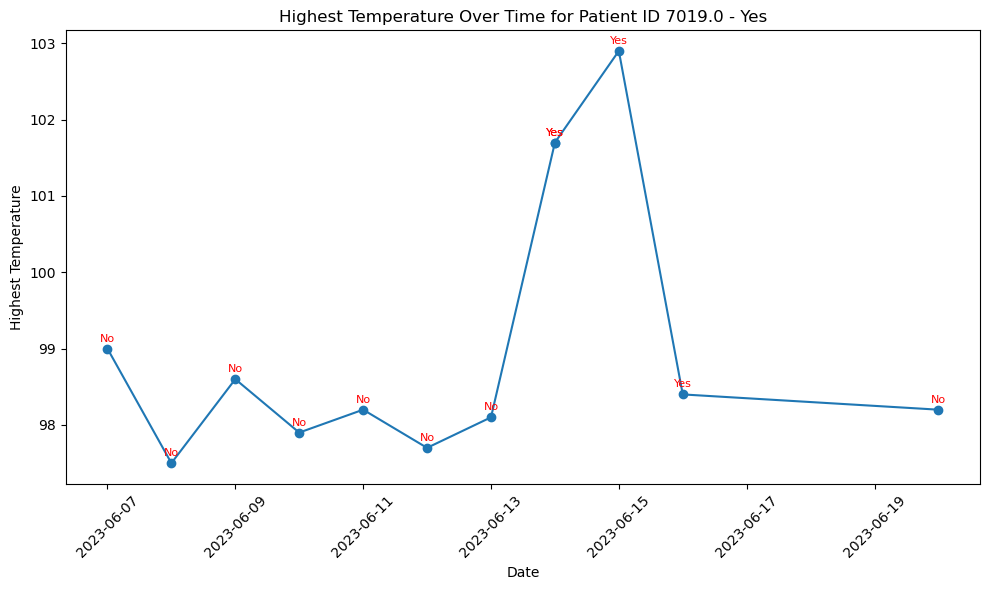

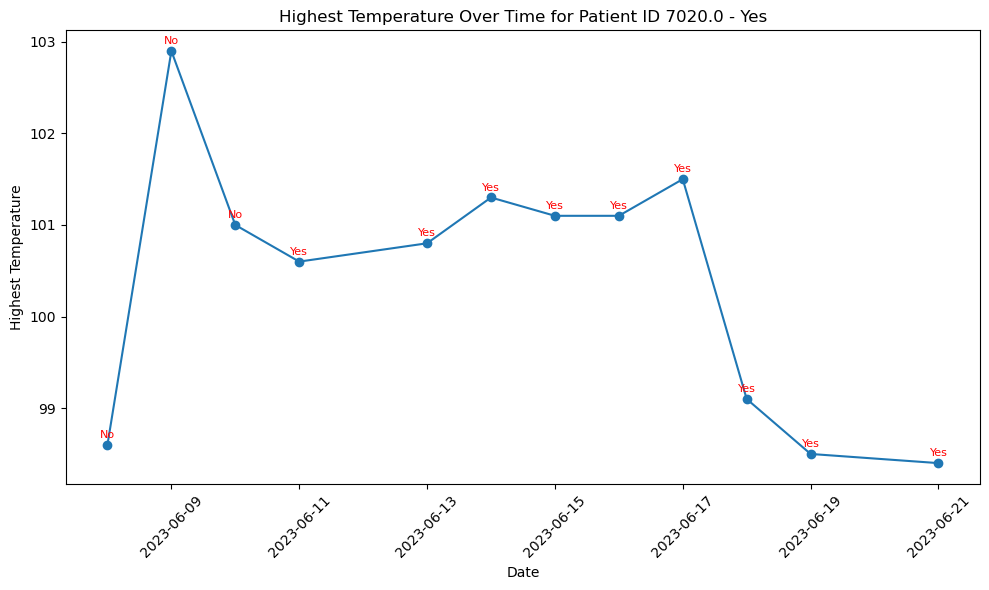

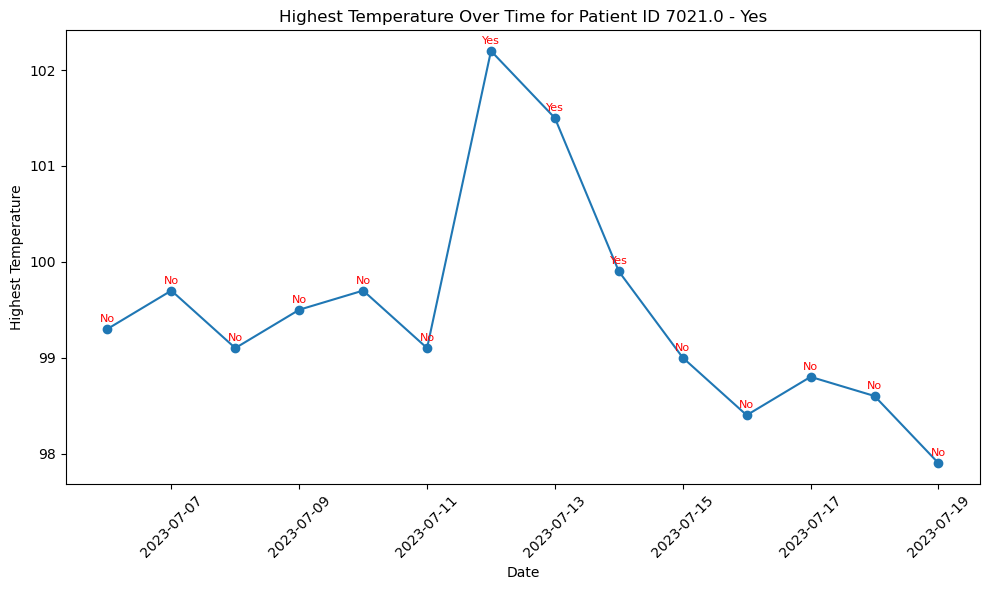

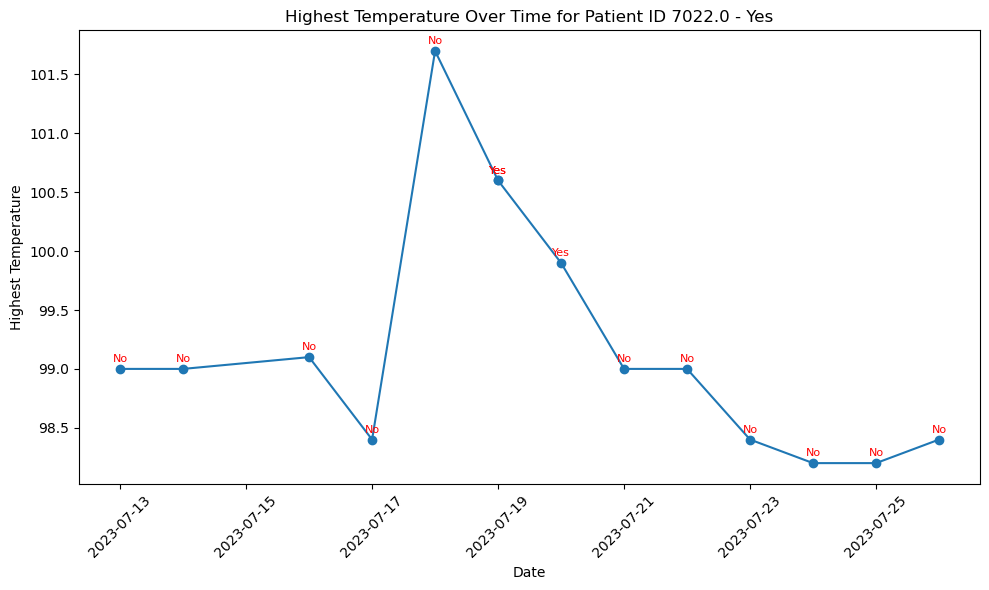

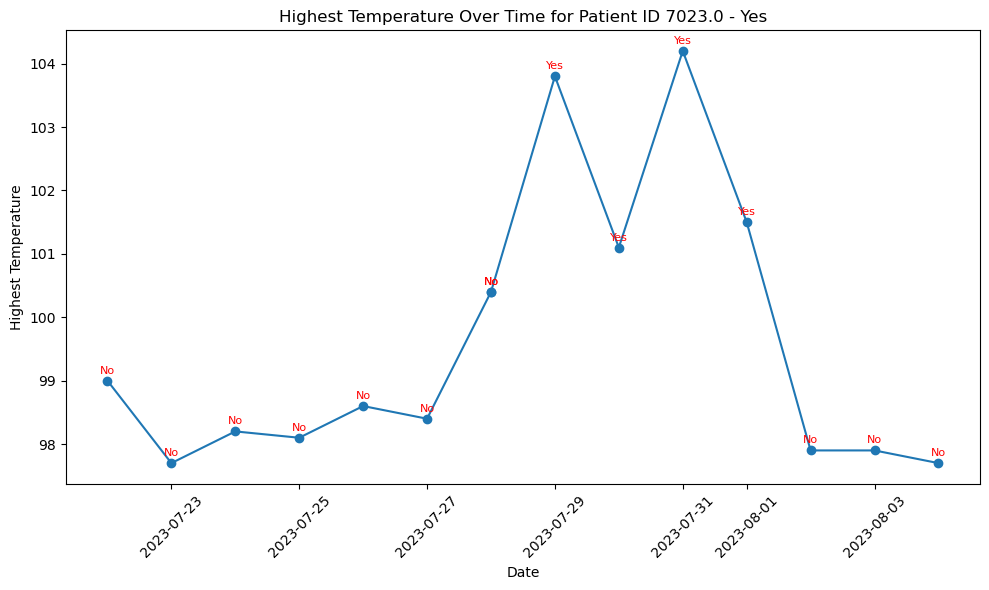

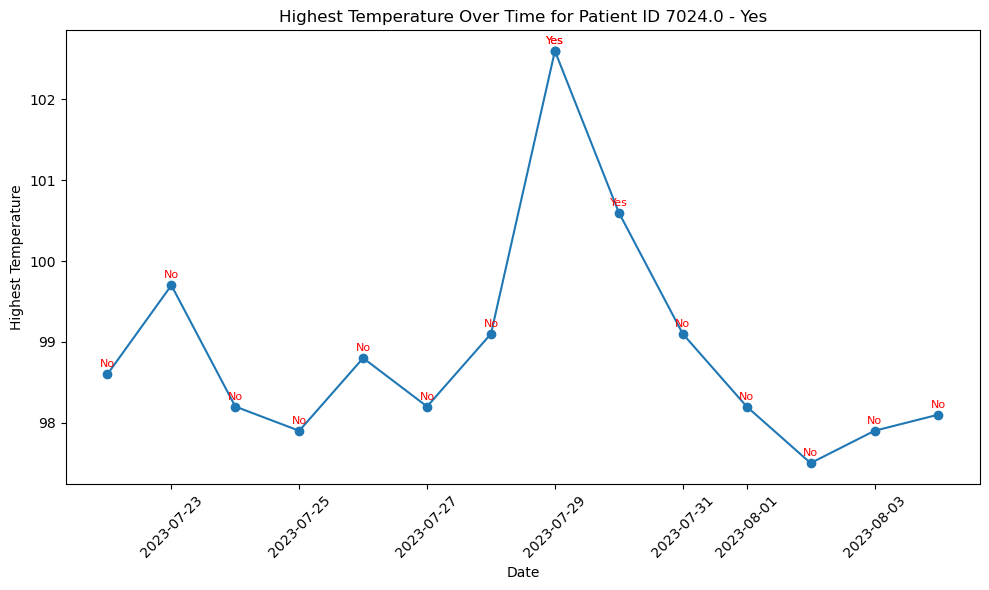

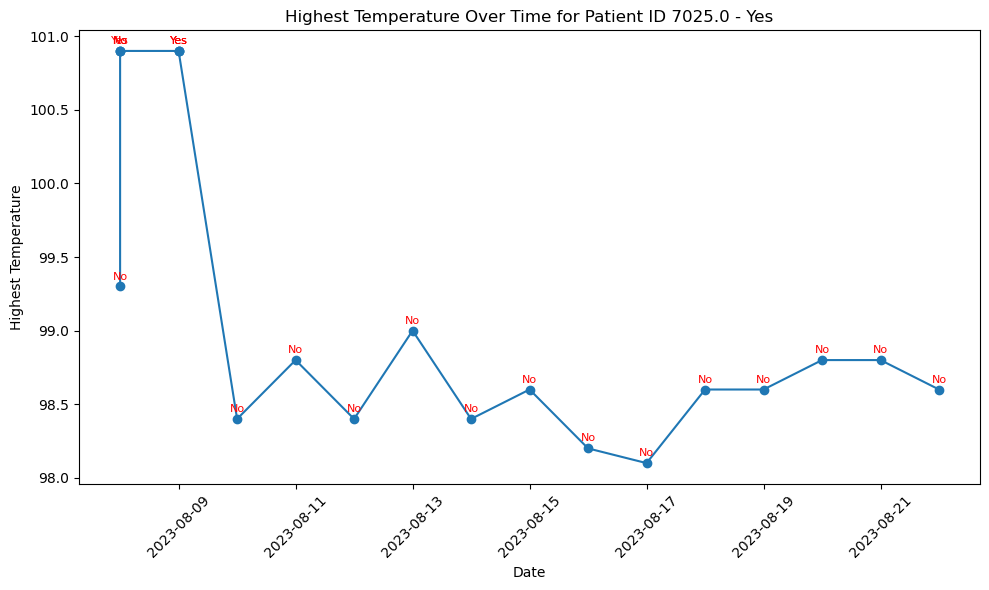

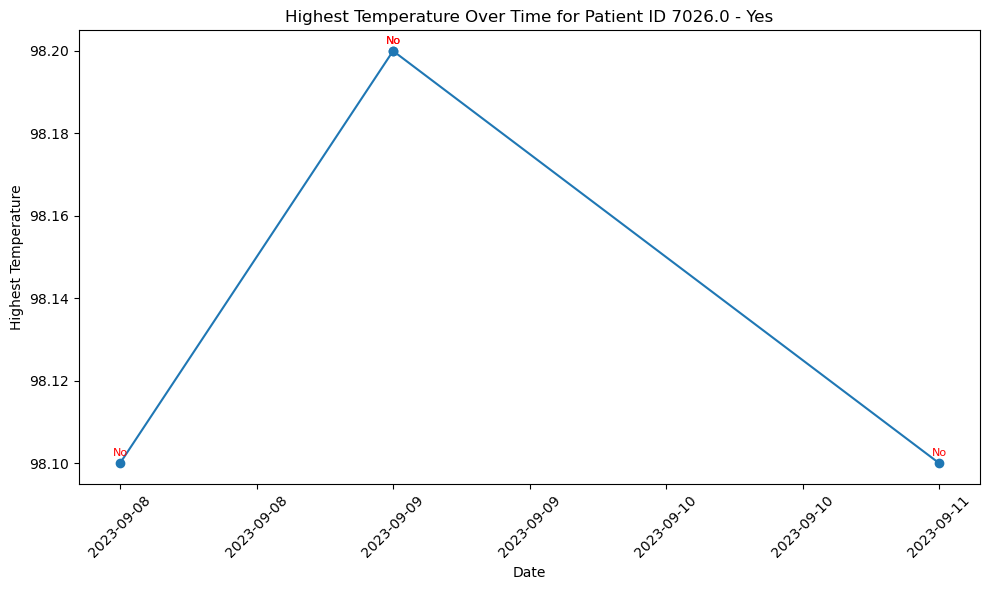

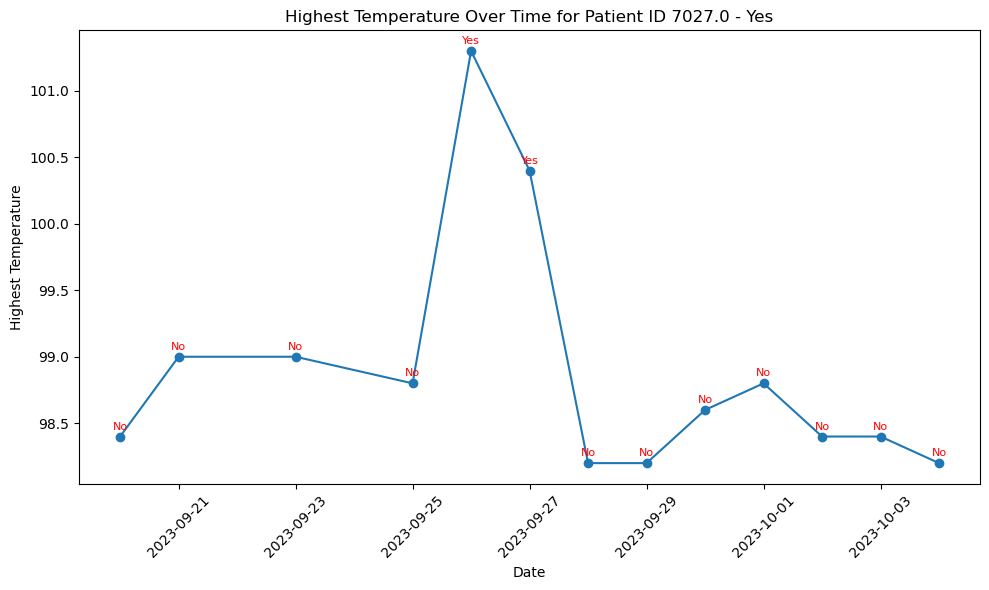

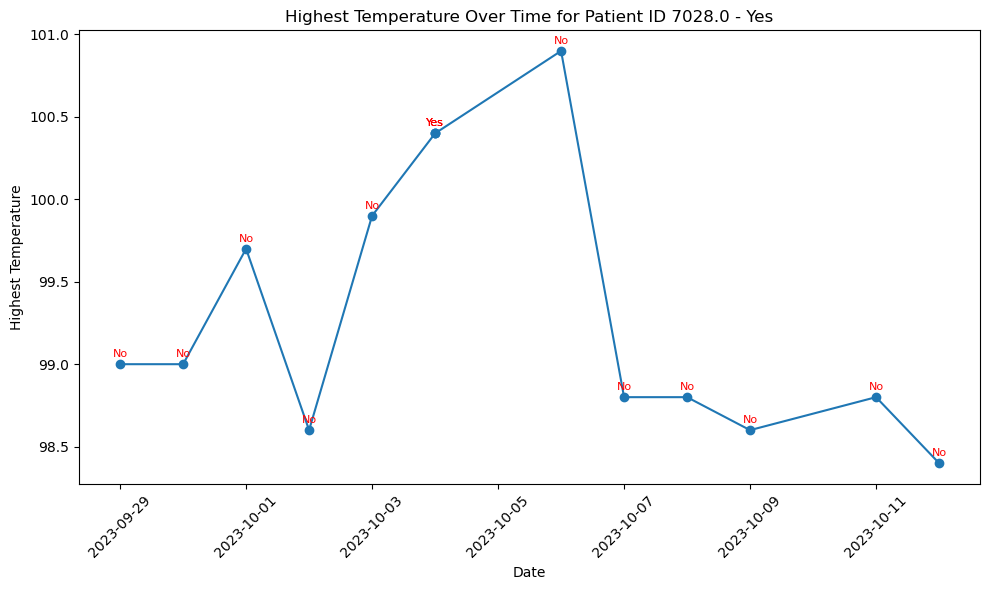

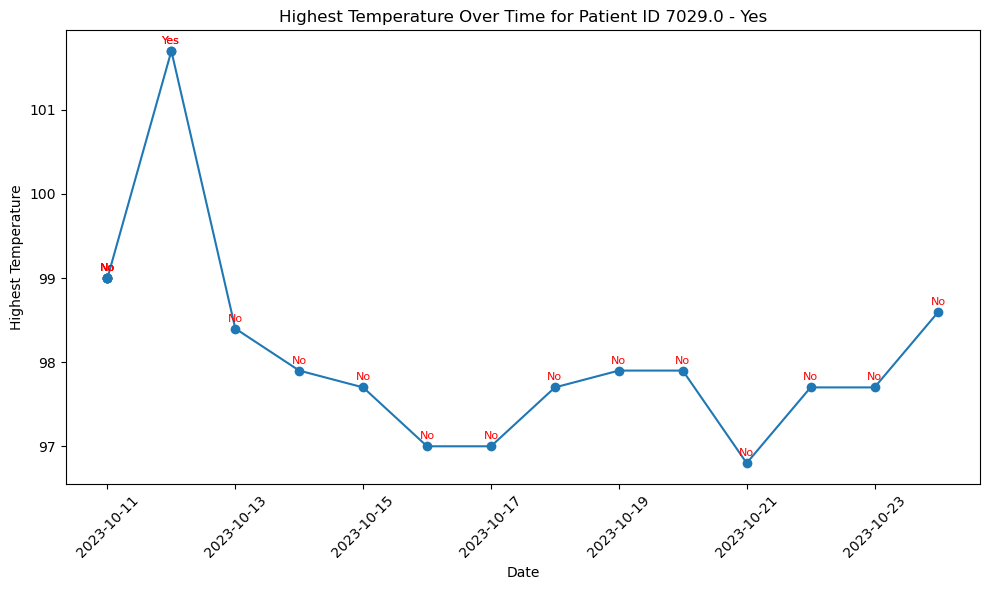

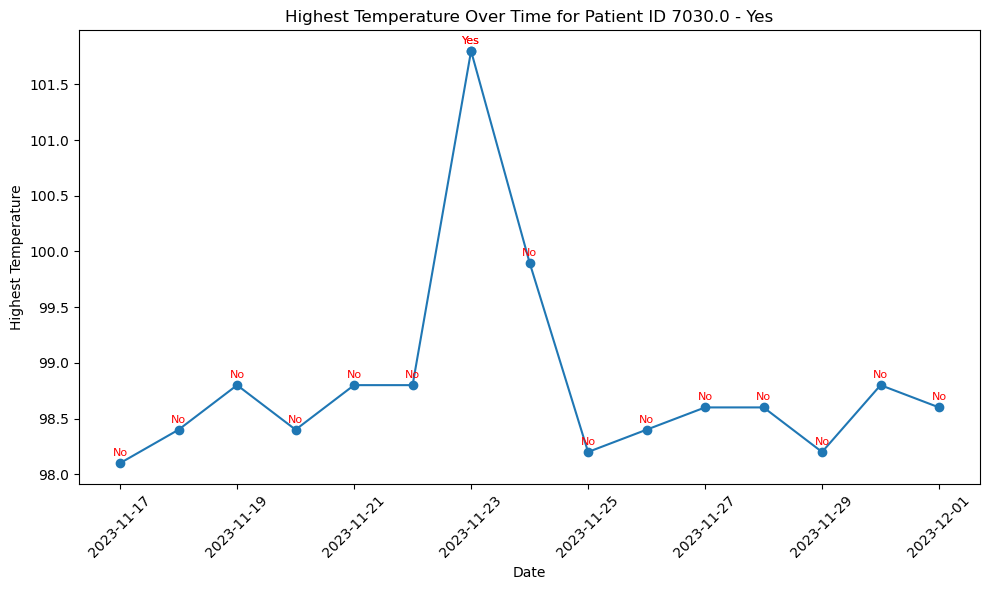

In [34]:
for name, group in grouped:
    plt.figure(figsize=(10, 6))
    
    # Plot the data
    plt.plot(group['Date of Sample'], group['Highest Temp'], marker='o', linestyle='-')
    CRS = group['Patient experienced CRS at any point (Yes/No)'].iloc[0]
    # Add text annotations for each point
    for idx, row in group.iterrows():
        crs_status = 'Yes' if row['CRS on date (0 No, 1 Yes)'] == 1 else 'No'
        plt.annotate(
            text=crs_status,
            xy=(row['Date of Sample'], row['Highest Temp']),
            xytext=(0, 5),
            textcoords='offset points',
            ha='center',
            fontsize=8,
            color='red'
        )
    
    # Formatting the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    
    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Highest Temperature')
    plt.title(f'Highest Temperature Over Time for Patient ID {name} - {CRS}')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()